### Изучение работы методов контроля температуры в молекулярной динамике

In [1]:
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem import Descriptors
from rdkit import RDConfig
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt

Посмотрим файл с типами атомов, найдем углерод и водород, входящие в алкан (opls_139, opls_140).

    !cat /usr/share/gromacs/top/oplsaa.ff/atomtypes.atp

Дальше смоделируем этан, получим для него связи, углы и двугранные углы.   

In [2]:
mol = Chem.MolFromSmiles('CC')
AllChem.Compute2DCoords(mol)

m3d = Chem.AddHs(mol)
Chem.AllChem.EmbedMolecule(m3d)
AllChem.MMFFOptimizeMolecule(m3d, maxIters=500, nonBondedThresh=200)

bonds = m3d.GetBonds()

In [3]:
for i, b in enumerate(bonds):
    print b.GetBeginAtomIdx() + 1, \
          b.GetEndAtomIdx() + 1, 1
print

for i, b1 in enumerate(bonds):
    for b2 in list(bonds)[i:]:
        if b1.GetBeginAtomIdx() == b2.GetBeginAtomIdx() and b1.GetIdx() != b2.GetIdx():
            print b1.GetEndAtomIdx() + 1 , \
                  b1.GetBeginAtomIdx() + 1, \
                  b2.GetEndAtomIdx() + 1, 1
        elif b1.GetEndAtomIdx() == b2.GetBeginAtomIdx():
            print b1.GetBeginAtomIdx() + 1, \
                  b1.GetEndAtomIdx() + 1, \
                  b2.GetEndAtomIdx() + 1, 1
print

for b1 in m3d.GetBonds():
    for b2 in m3d.GetBonds():
        for b3 in m3d.GetBonds():
             if b1.GetBeginAtomIdx() == b2.GetBeginAtomIdx() and \
                b2.GetEndAtomIdx() == b3.GetBeginAtomIdx() and \
                b1.GetIdx() != b2.GetIdx():
                print b1.GetEndAtomIdx() + 1, \
                      b1.GetBeginAtomIdx() + 1, \
                      b2.GetEndAtomIdx() + 1, \
                      b3.GetEndAtomIdx() + 1, 3

1 2 1
1 3 1
1 4 1
1 5 1
2 6 1
2 7 1
2 8 1

2 1 3 1
2 1 4 1
2 1 5 1
1 2 6 1
1 2 7 1
1 2 8 1
3 1 4 1
3 1 5 1
4 1 5 1
6 2 7 1
6 2 8 1
7 2 8 1

3 1 2 6 3
3 1 2 7 3
3 1 2 8 3
4 1 2 6 3
4 1 2 7 3
4 1 2 8 3
5 1 2 6 3
5 1 2 7 3
5 1 2 8 3


Полученные значения вставим в файл <b>et.top</b>.

In [4]:
et = """#include "/usr/share/gromacs/top/oplsaa.ff/forcefield.itp"

[ moleculetype ]
; Name            nrexcl
et            3

[ atoms ]
;   nr  type  resnr  residue  atom   cgnr     charge       mass
    1   opls_139      1    ETH      C1      1    -0.189      12.01
    2   opls_139      1    ETH      C2      2    -0.155      12.01
    3   opls_140      1    ETH      H1      3     0.0059       1.008
    4   opls_140      1    ETH      H2      4     0.0059       1.008
    5   opls_140      1    ETH      H3      5     0.0059       1.008
    6   opls_140      1    ETH      H4      6     0.0056       1.008
    7   opls_140      1    ETH      H5      7     0.0056       1.008
    8   opls_140      1    ETH      H6      8     0.0056       1.008
    
[ bonds ]
;  ai    aj funct  b0       kb
     1   2   1  
     1   3   1
     1   4   1  
     1   5   1 
     2   6   1
     2   7   1
     2   8   1

[ angles ]
;  ai    aj    ak funct  phi0   kphi
;around c1
    3     1     4     1  
    4     1     5     1  
    3     1     5     1  
    2     1     3     1  
    2     1     4     1  
    2     1     5     1  
;around c2
    7     2     8     1  
    8     2     6     1  
    7     2     6     1  
    1     2     6     1  
    1     2     7     1  
    1     2     8     1  

[ dihedrals ]
;  ai    aj    ak    al funct  
    3    1     2     6      3  
    3    1     2     7      3 
    3    1     2     8      3  
    4    1     2     6      3
    4    1     2     7      3 
    4    1     2     8      3
    5    1     2     6      3
    5    1     2     7      3
    5    1     2     8      3

[ pairs ]
; список атомов 1-4
;  ai    aj funct
   3  6
   3  7
   3  8
   4  6
   4  7
   4  8
   5  6
   5  7
   5  8

[ System ]
; any text here
first one
[ molecules ]
;Name count
 et    1
"""
with open('et.top','w') as top:
    top.write(et)

Далее загрузим файл <b>etane.gro</b> и <b>.mdp</b> файлы с разными параметрами контроля температуры.

In [ ]:
%%bash
wget http://kodomo.fbb.msu.ru/FBB/year_08/term6/etane.gro &> /dev/null
export i='be vr nh an sd'
for s in $i; do
wget http://kodomo.fbb.msu.ru/FBB/year_08/term6/$s.mdp &> /dev/null
done

Для файлов с параметрами с помощью <i>grompp</i> получим файлы для молекулярно-динамического движка и запустим моделирование в <i>mdrun</i>.

Тут же получим <b>.pdb</b> файл, чтобы посмотреть результаты. И почситаем потенциальную и кинетическую энергии для каждой системы.

In [ ]:
%%bash
export i='be vr nh an sd'
for s in $i; do
grompp -f $s.mdp -c etane.gro -p et.top -o et_$s.tpr &> /dev/null
mdrun -deffnm et_$s -v -nt 1 &> mdrun_res_$s.txt
echo 2 | trjconv -f et_$s.trr -s et_$s.tpr -o et_$s.pdb &> /dev/null
echo 10 11 | g_energy -f et_$s.edr -o et_en_$s.xvg -xvg none &> /dev/null
done

Посмотрим на визуализацию.

Метод Берендсена.
<img src='berendsen.gif' width="500" align="center">
Метод "Velocity rescale".
<img src='velocity_rescale.gif' width="500" align="center">
Метод Нуза-Хувера.
<img src='nose_hoover.gif' width="500" align="center">
Метод Андерсена.
<img src='andersen.gif' width="500" align="center">
Метод стохастической молекулярной динамики.
<img src='molecular_dynamics.gif' width="500" align="center">

Молекулы ведут себя по-разному: 
- в методе Андерсена практически не наблюдается никакого движения, происходит только небольшое колебание атомов водорода; 
- в методе молекулярной динамики вроде как конформация молекулы не меняется, но положение молекулы в пространстве изменяется очень активно; 
- в методе Нуза-Хувера происходит изменение двугранных углов (плоскости движутся в разные стороны), другого движения в пространстве не наблюдается; 
- метод Берендсена похож на предыдущий, но движение атомов сохраняет заторможенную конформацию, при этом изменяется положение молекулы в пространстве; 
- в методе "Velocity rescale" присутствует и колебание молекулы, и изменение углов, и движение в пространстве.

Построим графики изменения энергий для каждого метода.

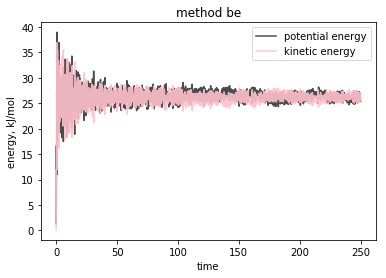

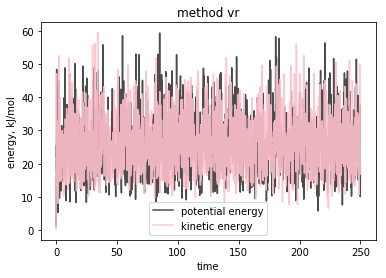

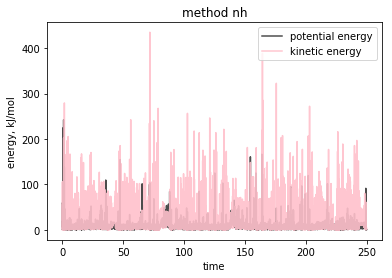

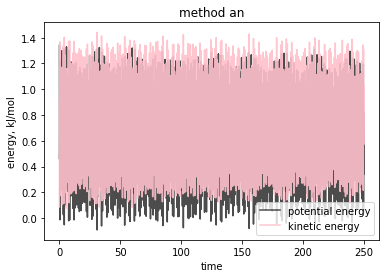

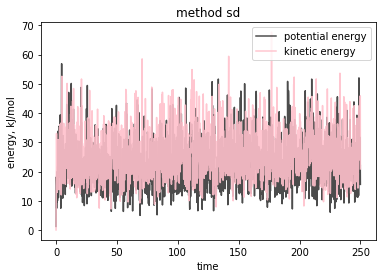

In [22]:
for method in ['be','vr','nh','an','sd']:
    data = np.loadtxt("et_en_" + method + '.xvg')
    t = data[:,0]
    potential = data[:,1]
    kinetic = data[:,2]
    plt.plot(t, potential, 'black', alpha = 0.7, label = 'potential energy')
    plt.plot(t, kinetic, 'pink', alpha = 0.9, label = 'kinetic energy')
    plt.title('method ' + method)
    plt.xlabel('time')
    plt.ylabel('energy, kJ/mol')
    plt.legend()
    plt.show()

Графики изменения энергии тоже различаются.
- у метода молекулярной динамики и метода "Velocity rescale" довольно похожие графики и визуально, и по дисперсии;
- на графике для метода Андерсена очень незначительные изменения высоты пиков, что закономерно, и очень маленький диапазон изменения энергии;
- судя по графику метода Берендсена, молекула стабилизируется, несмотря на то что активно крутится;
- в методе Нуза-Хувера самые большие изменения энергии, что, вероятно, вызвано тем, что в этой модели молекула этана принимает "неудобные" для себя конформации.

С помощью утилиты по анализу связей <i>g_bond</i> получим распределение длинны связи С-С за время моделирования.

In [ ]:
%%bash
export i='be vr nh an sd'
for s in $i; do
g_bond -f et_$s.trr -s et_$s.tpr -o bond_$s.xvg -n b.ndx -xvg none &> /dev/null
done

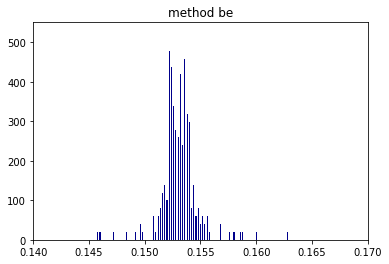

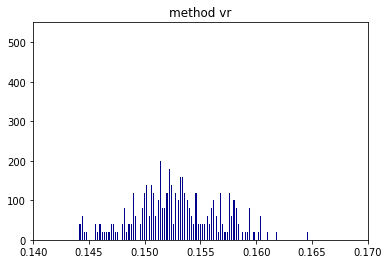

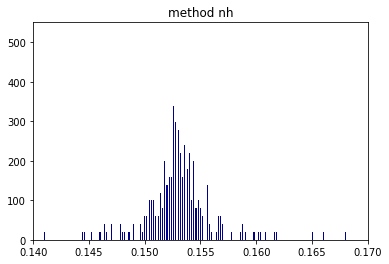

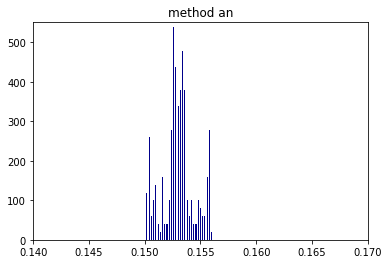

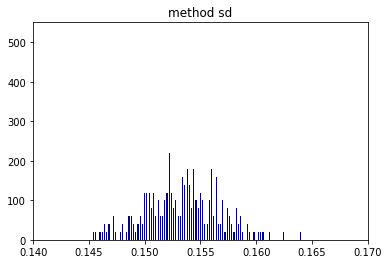

In [15]:
for method in ['be', 'vr', 'nh', 'an', 'sd']:
    bonds = np.loadtxt('bond_' + method + '.xvg')
    plt.bar(bonds[:, 0], bonds[:, 1], 0.0001, color = 'darkblue')
    plt.xlim(0.14, 0.17)
    plt.ylim(0, 550)
    plt.title('method ' + method)
    plt.show()

- Графики изменения длины связи у метода молекулярной динамики и метода "Velocity rescale" тоже достаточно похожи и по диапазону значений, и по высоте пиков;
- метод Нуза-Хувера имеет похожий разброс значений, но график отличается;
- длина связи C-C в методе Берендсена иногда имеет отклонения, но в целом достаточно стабильна;
- в методе Андерсена длина связи между двумя углеродами практически не изменяется, но колебания водородов всё же немного на неё влияют.

In [17]:
%%bash
export i='be vr nh an sd'
for s in $i; do
echo "$s"
tail -n 7 mdrun_res_$s.txt | head -2
done

be
               NODE (s)   Real (s)      (%)
       Time:      2.950      3.980     74.1
vr
               NODE (s)   Real (s)      (%)
       Time:      2.940      3.889     75.6
nh
               NODE (s)   Real (s)      (%)
       Time:      3.620      4.806     75.3
an
               NODE (s)   Real (s)      (%)
       Time:      2.890      3.783     76.4
sd
               NODE (s)   Real (s)      (%)
       Time:      3.440      4.655     73.9


Если учитывать форму распределения Больцмана, то наиболее реалистично поддерживать температуру в системе, вероятно, будет метод Берендсена. Он быстрый, молекула принимает достаточно стабильную для себя конформацию, при этом может продолжать двигаться, что обеспечит поддержку температуры на нужном уровне.

- Метод Андерсена плох тем, что молекула почти не двигается;
- метод Нуза-Хувера заставляет молекулу принимать конформации в которых она не бывает;
- метод молекулярной динамики и метод "Velocity rescale", скорее всего, неплохи, особенно последний, так как визуально он больше всего похож на правду, но оба метода самые вычислительно затратные.